In [49]:
from pokerkit import *
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# Visualizations
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [176]:
class PokerEnvironment:
    def __init__(self, config):
        self.config = config
        self.n_samples = config['monte_carlo_sample_size']

        # Start hand
        self.game_state = NoLimitTexasHoldem.create_state(
            automations=(
                Automation.ANTE_POSTING,
                Automation.BET_COLLECTION,
                Automation.BLIND_OR_STRADDLE_POSTING,
                Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                Automation.HAND_KILLING,
                Automation.CHIPS_PUSHING,
                Automation.CHIPS_PULLING
            ),
            ante_trimming_status=False,
            raw_antes=0,
            raw_blinds_or_straddles=(1,2),
            min_bet=2,
            raw_starting_stacks=(self.config['player_0_stack'], self.config['player_1_stack']),
            player_count=2,
            mode = Mode.CASH_GAME
        )

        # Initialize Variables
        self.raises = [0, 0]
        self.calls = [0, 0]
        self.played_hands = [0, 0]
        self.total_hands = 0

        self.last_pot_size = -999
        self.is_complete = False
        self.has_played_current_hand = [False, False]
        self.hand_state = 0
        self.total_hands += 1
        # Deal Preflop Cards
        for i in range(4):
            self.game_state.deal_hole()
        self.pot_size = self.game_state.total_pot_amount


    def reset(self):
        stacks = self.game_state.stacks
        if self.stack[0] == 0:
            print('PLAYER 0 RAN OUT OF MONEY')
            stacks[0] = self.config['player_0_stack']
        elif self.stack[1] == 0:
            print('PLAYER 1 RAN OUT OF MONEY')
            stacks[1] = self.config['player_1_stack']
        else:
            self.game_state = NoLimitTexasHoldem.create_state(
                automations=(
                    Automation.ANTE_POSTING,
                    Automation.BET_COLLECTION,
                    Automation.BLIND_OR_STRADDLE_POSTING,
                    Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                    Automation.HAND_KILLING,
                    Automation.CHIPS_PUSHING,
                    Automation.CHIPS_PULLING
                ),
                ante_trimming_status=False,
                raw_antes=0,
                raw_blinds_or_straddles=(1,2),
                min_bet=2,
                raw_starting_stacks=(stacks[0], stacks[1]),
                player_count=2,
                mode = Mode.CASH_GAME
            )

            self.last_pot_size = -999
            self.is_complete = False
            self.has_played_current_hand = [False, False]
            self.hand_state = 0
            self.total_hands += 1
            # Deal Preflop Cards
            for i in range(4):
                self.game_state.deal_hole()
            self.pot_size = self.game_state.total_pot_amount


        
    def get_state(self, player_index):
        if player_index < 0 or player_index > 1 :
            raise Exception('Player Index can only be 0 or 1')
        hand = self.game_state.hole_cards[player_index]
        board = self.game_state.board_cards
        hand_strength = self._calculate_hand_strength(hand, board, self.n_samples)
        # TODO:: Hand Potential
        hand_state = self.hand_state # are we preflop, flop, turn, or river
        bets = self.game_state.bets
        pot_size = self.pot_size
        if player_index == 0:
            money_to_call = max(bets[1] - bets[0], 0)
            stack = self.game_state.stacks[0]
            af = self._calculate_af(self.raises[1], self.calls[1]) # calculate player 1's af
            lh = self._calculate_lh(self.played_hands[1])
        else:
            money_to_call = max(bets[0] - bets[1], 0)
            stack = self.game_state.stacks[1]
            af = self._calculate_af(self.raises[0], self.calls[0]) # calculate player 0's af
            lh = self._calculate_lh(self.played_hands[0])
        
        return {'stack': stack,
                'pot_size': pot_size,
                'money_to_call': money_to_call,
                'hand_strength': hand_strength,
                'af': af,
                'lh': lh,
                'hand_state': hand_state,
                'done': self.is_complete}
    

    def _calculate_af(self, raises, calls):
        if calls == 0:
            af = -1
        else:
            af = raises / calls
        return af
    
    def _calculate_lh(self, played_hands):
        if self.total_hands < 10:
            lh = 1#0.75
        else:
            lh = played_hands / self.total_hands
        return lh
    

    def _calculate_hand_strength(self, hand, board, n_samples):
        hand = frozenset([frozenset(hand)])
        #print(hand)
        board = frozenset([x[0] for x in board])
        #print(board)
        strength = calculate_hand_strength(
            player_count= 2,
            hole_range = hand,
            board_cards = board,
            hole_dealing_count=2,
            board_dealing_count=5,
            deck=Deck.STANDARD,
            hand_types=(StandardHighHand,),
            sample_count=n_samples,
            #executor=executor
        )
        return strength


    def _calculate_hand_potential(self, hand, board, n_samples):
        return 0.5
    

    def _calculate_opponent_hand_potential(self, your_hand, board, outer_sim_samples, inner_sim_samples):
        potentials = list()
        for i in range(outer_sim_samples):
            potentials.append(self._calculate_hand_potential(your_hand, board, inner_sim_samples))
        return np.mean(potentials)


    def step(self, action, player_index):
        self.is_complete = False

        # Handle Folds
        if not action['fold']:
            self.has_played_current_hand[player_index] = True
        else:
            self.game_state.fold()
            self.is_complete = True

        # Handle Checks or Calls 
        if action['check_or_call']:
            output = self.game_state.check_or_call()
            self.calls[player_index] += 1
            self.pot_size += output.amount

        # Handle Raises
        if action['raise']:
            output = self.game_state.complete_bet_or_raise_to(action['bet_size'])
            self.raises[player_index] += 1
            self.pot_size += output.amount

        
        # Check if game is over
        is_player_0_in_hand = self.game_state.statuses[0]
        is_player_1_in_hand = self.game_state.statuses[1]
        if not (is_player_0_in_hand and is_player_1_in_hand):
            self.is_complete = True

        # Handle if players are all in
        if self.game_state.all_in_status:
            self.select_runout_count(1)
            self.select_runout_count(1)
            while self.game_state.can_burn_card():
                self.hand_state += 1
                self.game_state.burn_card()
                self.game_state.deal_board()
            self.is_complete = True

        if self.is_complete:
            if self.has_played_current_hand[0]:
                self.played_hands[0] += 1
            if self.has_played_current_hand[1]:
                self.played_hands[1] += 1
            

        # Increment hand state
        if self.game_state.can_burn_card():
            self.hand_state += 1
            self.game_state.burn_card()
            self.game_state.deal_board()
        
        return self.is_complete


    def reward(self, state, player_index):
        # Handle reward if user won/lost
        if state['done']:
            did_win = self.game_state.statuses[player_index]
            if did_win:
                return state['pot_size']
            else:
                return -1 * state['pot_size']
        # Handle reward if mid hand
        epsilon = 0.001
        return ((state['hand_strength'] ** (1/(state['lh'] + epsilon))) - (1 - (state['hand_strength'] ** (1/(state['lh'] + epsilon))))) * state['pot_size']

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)    #First fully connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)    #Second fully connected layer
        self.fc3 = nn.Linear(hidden_size, 1)    #Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))    #ReLU activation for the first layer
        x = F.relu(self.fc2(x))    #ReLU activation for the second layer
        x = self.fc3(x)    #Output layer (no activation because this is a regression problem)
        return x

In [145]:
class BaseAgent:
    def __init__(self, config):
        self.config = config
    
    def policy(self, state, epsilon):
        return self.config['A'][0]

In [146]:
def handle_action(raw_action):
    """
    Clean's agent's action into something the environment can handle
    """
    if raw_action == 'check_or_call':
        return {'fold': False,
                'check_or_call' : True,
                'raise': False,
                'bet_size': 0 #technically only need this when raise = True
                }

In [116]:
list(Card.parse('3dKc2d'))

[3d, Kc, 2d]

In [175]:
config = {'monte_carlo_sample_size': 300,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})

done = False

while not done:

    agent_0_state = poker.get_state(0)
    agent_1_state = poker.get_state(1)
    print(poker.get_state(0))
    print(poker.get_state(1))

    print(f"agent 0 reward: {poker.reward(agent_0_state, 0)}")
    print(f"agent 1 reward: {poker.reward(agent_1_state, 1)}")

    agent_0_action = agent_0.policy(agent_0_state, 1)
    agent_1_action = agent_1.policy(agent_1_state, 1)

    agent_0_action = handle_action(agent_0_action)
    agent_1_action = handle_action(agent_1_action)

    done = poker.step(agent_1_action, 1)
    if not done:
        done = poker.step(agent_0_action, 0)
print(poker.get_state(0))
print(poker.get_state(1))


agent_0_state = poker.get_state(0)
agent_1_state = poker.get_state(1)

print(f"agent 0 reward: {poker.reward(agent_0_state, 0)}")
print(f"agent 1 reward: {poker.reward(agent_1_state, 1)}")

{'stack': 198, 'pot_size': 3, 'money_to_call': 0, 'hand_strength': 0.5616666666666666, 'af': -1, 'lh': 1, 'hand_state': 0, 'done': False}
{'stack': 199, 'pot_size': 3, 'money_to_call': 1, 'hand_strength': 0.6266666666666667, 'af': -1, 'lh': 1, 'hand_state': 0, 'done': False}
agent 0 reward: 0.20201016927965276
agent 1 reward: 0.7017873232652481
{'stack': 198, 'pot_size': 4, 'money_to_call': 0, 'hand_strength': 0.49666666666666665, 'af': 0.0, 'lh': 1, 'hand_state': 1, 'done': False}
{'stack': 198, 'pot_size': 4, 'money_to_call': 0, 'hand_strength': 0.5683333333333334, 'af': 0.0, 'lh': 1, 'hand_state': 1, 'done': False}
agent 0 reward: 0.08274542455746836
agent 1 reward: 1.3754701712451096
{'stack': 198, 'pot_size': 4, 'money_to_call': 0, 'hand_strength': 0.37166666666666665, 'af': 0.0, 'lh': 1, 'hand_state': 2, 'done': False}
{'stack': 198, 'pot_size': 4, 'money_to_call': 0, 'hand_strength': 0.5916666666666667, 'af': 0.0, 'lh': 1, 'hand_state': 2, 'done': False}
agent 0 reward: -0.99705

In [138]:
poker.get_state(0)

{'stack': 202,
 'pot_size': 0,
 'money_to_call': 0,
 'hand_strength': 0.475,
 'af': 0.0,
 'lh': 0.75,
 'hand_state': 3,
 'done': True}

In [137]:
list(poker.game_state.pots)

[Pot(raked_amount=0, unraked_amount=0, player_indices=(0,))]

In [126]:
poker.game_state.statuses

[True, False]

In [125]:
poker.get_state(1)

frozenset({frozenset()})
frozenset({4s, 2d, 6s, Th, 2c})


{'stack': 198,
 'pot_size': 0,
 'money_to_call': 0,
 'hand_strength': 0.515,
 'af': 0.0,
 'lh': 0.75,
 'hand_state': 3}

False

In [98]:
poker.game_state.board_cards

[[6h], [Th], [3s]]

In [ ]:
agent_0.policy()

100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


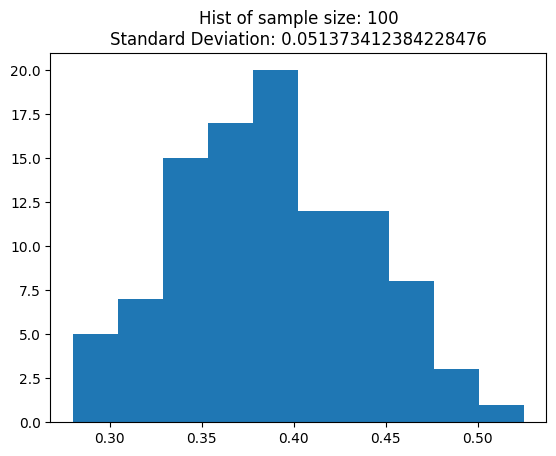

In [64]:
sample_size = 100
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


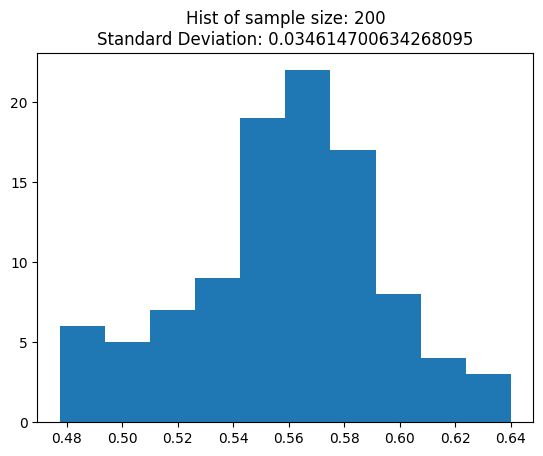

In [65]:
sample_size = 200
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


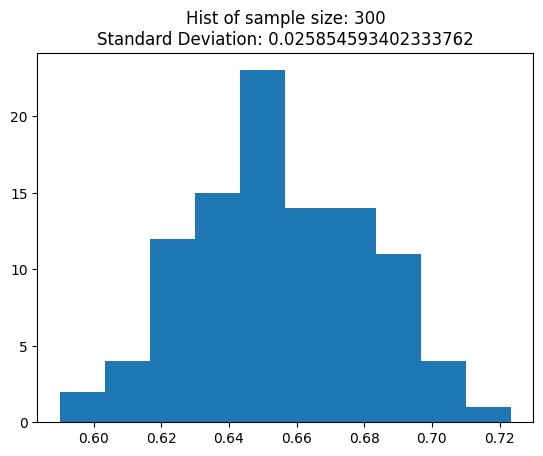

In [71]:
sample_size = 300
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


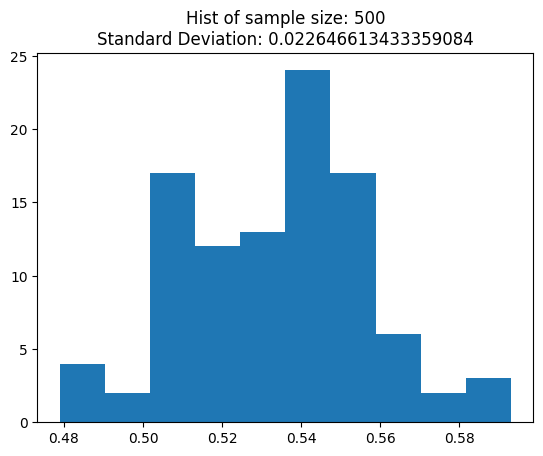

In [67]:
sample_size = 500
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


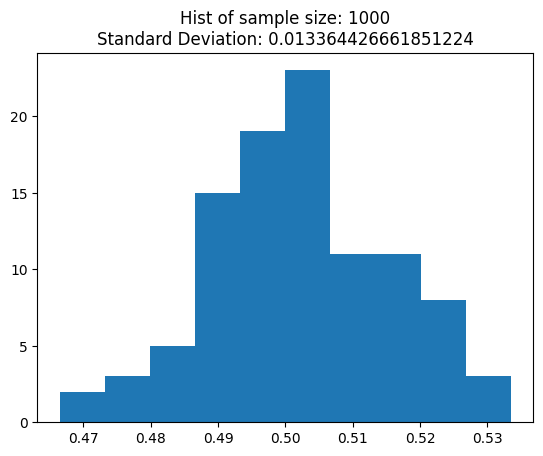

In [47]:
sample_size = 1000
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

In [62]:
sample_size = 3_000
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

 15%|█▌        | 15/100 [00:27<02:33,  1.81s/it]


KeyboardInterrupt: 

In [ ]:
# sample size: 500
sample_size = 500
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}')
plt.show()

print(f'Standard Deviation: {np.std(strengths)}')

Standard Deviation: 0.022124646889837566


In [26]:
poker.get_state(1)

{'stack': 199,
 'pot_size': 3,
 'money_to_call': 1,
 'hand_strength': 0.534,
 'af': -1,
 'lh': 0.75,
 'hand_state': 0}

In [61]:
calculate_hand_strength(
            player_count= 2,
            hole_range = [['Qs','2h']],
            board_cards = [],
            hole_dealing_count=2,
            board_dealing_count=5,
            deck=Deck.STANDARD,
            hand_types=(StandardHighHand,),
            sample_count=1000,
            executor=None
        )

AttributeError: 'str' object has no attribute 'rank'

In [167]:
state = NoLimitTexasHoldem.create_state(
    (
        Automation.ANTE_POSTING,
        Automation.BET_COLLECTION,
        Automation.BLIND_OR_STRADDLE_POSTING,
        Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
        Automation.HAND_KILLING,
        Automation.CHIPS_PUSHING,
        Automation.CHIPS_PULLING
    ),
    True,
    0,
    (1,2),
    2,
    200,
    2,
    mode=Mode.CASH_GAME,
)

### First Round of Betting

In [126]:
len(state.board_cards)

0

In [168]:
print(state.deal_hole())
print(state.deal_hole())
print(state.deal_hole())
print(state.deal_hole())

HoleDealing(commentary=None, player_index=0, cards=(Kh,), statuses=(False,))
HoleDealing(commentary=None, player_index=1, cards=(6d,), statuses=(False,))
HoleDealing(commentary=None, player_index=0, cards=(9d,), statuses=(False,))
HoleDealing(commentary=None, player_index=1, cards=(Ah,), statuses=(False,))


In [169]:
print(state.check_or_call())
print(state.check_or_call())

CheckingOrCalling(commentary=None, player_index=1, amount=1)
CheckingOrCalling(commentary=None, player_index=0, amount=0)


### Flop

In [170]:
print(state.burn_card())

CardBurning(commentary=None, card=Ad)


In [171]:
state.street

Street(card_burning_status=True, hole_dealing_statuses=(), board_dealing_count=3, draw_status=False, opening=<Opening.POSITION: 'Position'>, min_completion_betting_or_raising_amount=2, max_completion_betting_or_raising_count=None)

In [172]:
print(state.deal_board())

BoardDealing(commentary=None, cards=(5c, Qd, 4s))


In [144]:
#state.complete_bet_or_raise_to(198)

CompletionBettingOrRaisingTo(commentary=None, player_index=0, amount=198)

In [174]:
state.check_or_call()

CheckingOrCalling(commentary=None, player_index=1, amount=0)

In [175]:
list(state.pot_amounts)

[4]

In [176]:
state.can_burn_card()

True

In [177]:
state.burn_card()
state.deal_board()

BoardDealing(commentary=None, cards=(Ks,))

In [178]:
state.stacks

[198, 198]

In [179]:
state.can_burn_card()

False

In [180]:
state.can_deal_board()

False

In [181]:
output = state.complete_bet_or_raise_to(5)

In [182]:
state.can_fold()

True

In [183]:
state.board_cards

[[5c], [Qd], [4s], [Ks]]

In [184]:
state.check_or_call()

CheckingOrCalling(commentary=None, player_index=1, amount=5)

In [185]:
state.showdown_index

In [186]:
state.street

Street(card_burning_status=True, hole_dealing_statuses=(), board_dealing_count=1, draw_status=False, opening=<Opening.POSITION: 'Position'>, min_completion_betting_or_raising_amount=2, max_completion_betting_or_raising_count=None)

In [187]:
len(state.board_cards)

4

In [188]:
state.burn_card()
state.deal_board()

BoardDealing(commentary=None, cards=(3h,))

In [189]:
print(state.check_or_call())
print(state.check_or_call())

CheckingOrCalling(commentary=None, player_index=0, amount=0)
CheckingOrCalling(commentary=None, player_index=1, amount=0)


In [193]:
state.statuses

[True, False]

In [192]:
state

State(automations=(<Automation.ANTE_POSTING: 'Ante posting'>, <Automation.BET_COLLECTION: 'Bet collection'>, <Automation.BLIND_OR_STRADDLE_POSTING: 'Blind or straddle posting'>, <Automation.HOLE_CARDS_SHOWING_OR_MUCKING: 'Hole cards showing or mucking'>, <Automation.HAND_KILLING: 'Hand killing'>, <Automation.CHIPS_PUSHING: 'Chips pushing'>, <Automation.CHIPS_PULLING: 'Chips pulling'>), deck=<Deck.STANDARD: (2c, 2d, 2h, 2s, 3c, 3d, 3h, 3s, 4c, 4d, 4h, 4s, 5c, 5d, 5h, 5s, 6c, 6d, 6h, 6s, 7c, 7d, 7h, 7s, 8c, 8d, 8h, 8s, 9c, 9d, 9h, 9s, Tc, Td, Th, Ts, Jc, Jd, Jh, Js, Qc, Qd, Qh, Qs, Kc, Kd, Kh, Ks, Ac, Ad, Ah, As)>, hand_types=(<class 'pokerkit.hands.StandardHighHand'>,), streets=(Street(card_burning_status=False, hole_dealing_statuses=(False, False), board_dealing_count=0, draw_status=False, opening=<Opening.POSITION: 'Position'>, min_completion_betting_or_raising_amount=2, max_completion_betting_or_raising_count=None), Street(card_burning_status=True, hole_dealing_statuses=(), board_dea

### Turn

In [169]:
print(state.burn_card())

CardBurning(commentary=None, card=Ks)


In [170]:
print(state.deal_board())

BoardDealing(commentary=None, cards=(3c,))


In [171]:
print(state.complete_bet_or_raise_to(4))
print(state.check_or_call())

CompletionBettingOrRaisingTo(commentary=None, player_index=0, amount=4)
CheckingOrCalling(commentary=None, player_index=1, amount=4)


### River

In [172]:
print(state.burn_card())

CardBurning(commentary=None, card=5c)


In [173]:
print(state.deal_board())

BoardDealing(commentary=None, cards=(3s,))


In [174]:
print(state.check_or_call())
print(state.check_or_call())

CheckingOrCalling(commentary=None, player_index=0, amount=0)
CheckingOrCalling(commentary=None, player_index=1, amount=0)


In [175]:
state.payoffs

[6, -6]

In [176]:
state.can_deal_hole()

False

In [177]:
state.can_burn_card()

False

In [178]:
state.can_collect_bets()

False

In [179]:
state.can_no_operate()

True

In [180]:
state.can_complete_bet_or_raise_to()

False

In [181]:
state.can_kill_hand()

False

In [182]:
state.can_pull_chips()

False

In [183]:
state.can_push_chips()

False

In [187]:
state.can_win_now(0)

True

In [185]:
state.can_show_or_muck_hole_cards()

False

In [186]:
state.can_stand_pat_or_discard()

False

In [ ]:
state.

False